<a href="https://colab.research.google.com/github/sfbllgrn/DD2412_Class_Contrastive_Explanations/blob/main/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports


from torchvision.models import densenet161, DenseNet161_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import mnasnet0_5, MNASNet0_5_Weights # Här gissar jag att dom använder 0.5, står inte någonstans
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.models import vgg16, VGG16_Weights


import numpy as np
import torch
from torch.autograd.functional import jacobian as J
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import sys
from torchvision import transforms
from torch import nn
from torch.nn.functional import one_hot
from datetime import datetime
import json
import os



In [2]:
device = torch.device("cuda")

use_device = True

print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)


CUDA version: 11.8
PyTorch version: 2.1.1+cu118


In [3]:
# Load data
torch.cuda.empty_cache()
# when data is stored locally
#data_folder = "/Users/sofia/Documents/Skola/KTH/Master/Deep Learning, Advanced Course DD2412/Class Contrastive Explanations/DD2412_Class_Contrastive_Explanations/Data_small"


# for data stored on google drive
data_folder = "/home/sofia/data/val"
data_obj = ImageFolder(root=data_folder, transform=DenseNet161_Weights.DEFAULT.transforms())

BATCH_SIZE = 1
val_dataloader = DataLoader(data_obj, batch_size=BATCH_SIZE, shuffle=False)



In [4]:
# Perform gradient sign pertubations

def calculate_weighted_contrast(x, t, net):
  """Calculated weighted attribute explanation.
  Inputs:
    - X: one tensor input data (image), with shape (1,3,224,224)
    - t: one-dimensional tensor containing target class for the input img
    - net: network model"""

  logits = net(x)
  num_classes = logits.shape[1]
  phi_t = calculate_gradient(x, t, net)

  weighted_explanation = phi_t
  alpha_denominator = torch.sum(torch.exp(logits), dim=1)-torch.exp(logits[0,t])
  check_alpha_sum = 0
  for s in range(num_classes):
    if s!=t:
      alpha_s = torch.exp(logits[0,s])/alpha_denominator
      check_alpha_sum += alpha_s  # this can be checked if it sums to 1, for debug
      s = torch.tensor([s]).to(device) if use_device else torch.tensor([s])
      phi_s = calculate_gradient(x, s, net)
      weighted_explanation -= alpha_s*phi_s

  return weighted_explanation


def calculate_mean_contrast(x, t, net):
    logits = net(x)
    num_classes = logits.shape[1]
    phi_t = calculate_gradient(x,t,net)
    mean_contrast = phi_t
    for s in range(num_classes):
      if s!=t:
        s = torch.tensor([s]).to(device) if use_device else torch.tensor([s])   # put the index s in a tensor of the same type/shape as target tensor t
        phi_s = calculate_gradient(x,s,net)
        mean_contrast -= phi_s/(num_classes-1)

    return mean_contrast


def calculate_max_contrast(x, t, net):
  logits = net(x)
  num_classes = logits.shape[1]
  if BATCH_SIZE==1:
    logits[0,t] = -100000000  # because we want to take argmax on logits except t. I assume that there will always be a logit larger than this value
  else:
    logits[torch.arange(BATCH_SIZE), t] = -100000000
  s_star = torch.argmax(logits, dim=1)
  phi_s_star = calculate_gradient(x, s_star, net)
  phi_t = calculate_gradient(x, t, net)
  return phi_t - phi_s_star


def get_attribute_explanation(x, t, net, contrast_type):
  if contrast_type=="original":
    return calculate_gradient(x, t, net)
  elif contrast_type=="weighted":
    #return calculate_weighted_contrast(x, t, net)  # weighted contrast can be calculated with regular gradient method according to prop. 2
    return calculate_gradient(x, t, net, probs=True)
  elif contrast_type=="mean":
    return calculate_mean_contrast(x, t, net)
  elif contrast_type=="max":
    return calculate_max_contrast(x, t, net)


def calculate_gradient(x, t, net, probs=False):
  logits = net(x)
  pred_probab = nn.Softmax(dim=1)(logits)
  yt_oh = one_hot(t, num_classes=logits.shape[1])
  external_grad = torch.reshape(yt_oh, logits.shape)

  x.grad = None
  if probs:
    pred_probab.backward(gradient=external_grad)
    return x.grad

  logits.backward(gradient=external_grad)
  return x.grad


def gradient_sign_pertube(x, t, net, N, contrast_type="original"):
  epsilon = torch.tensor(1e-3).to(device)
  xn = x.clone()
  saved_iterations = []
  perturbation_direction = torch.sign(get_attribute_explanation(x, t, net, contrast_type))
  clamp_lower_limit = torch.minimum(x-epsilon, torch.tensor(0).to(device))
  clamp_upper_limit = torch.maximum(x+epsilon, torch.tensor(1).to(device))
  for n in range(1,N+1):
    # I artikeln madry et al. adversarial attacks har dom originaldata här nedan
    alpha = epsilon/n
    xn = xn + alpha*perturbation_direction
    xn = torch.clamp(xn, min=clamp_lower_limit, max=clamp_upper_limit)

    if n in [1,2,10]:
      saved_iterations.append(xn.clone())

  return saved_iterations


In [2]:
# Init Pretrained model (only one at a time due to memory limitations)

model_name = "efficientnet"

perturbation_types = ["weighted", "original", "max"] # skip "mean" for now, because it takes a lot of time

if model_name == "alexnet":
    pretrained_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1) #klar
elif model_name == "densenet":# 
    pretrained_model = densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1) #klar
elif model_name == "mobilenet_small":
    pretrained_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
elif model_name == "googlenet":
    pretrained_model = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
elif model_name == "mnasnet":
    pretrained_model = mnasnet0_5(weights=MNASNet0_5_Weights.IMAGENET1K_V1)
elif model_name == "resnet":
    pretrained_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
elif model_name == "mobilenet_large":
    pretrained_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)  # Denna har även IMAGENET1K_v2
elif model_name == "efficientnet":
    pretrained_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1) # Denna har även IMAGENET1K_v2
elif model_name == "vgg16":
    pretrained_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)


In [ ]:

N=10

torch.cuda.empty_cache()

model = pretrained_model.to(device) if use_device else pretrained_model
model.eval()

n_batches = int(len(data_obj)/BATCH_SIZE)           # eval on small subset, for debug

accuracy_dict = {i:{p_type:0 for p_type in perturbation_types} for i in [1,2,10]}
accuracy_unperturbed = 0
perturbation_changes = {i:{key:{"yt":[], "pt":[]} for key in perturbation_types} for i in [1,2,10]}

for batch_idx, (input, target) in enumerate(val_dataloader):
  if batch_idx%10000 == 0:
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

  if batch_idx%100==0:
      print("{} percent done".format(batch_idx*100/n_batches))


  if batch_idx < n_batches and len(input)==BATCH_SIZE:

      if use_device:
          input = input.to(device)          
          target = target.to(device)

      input.requires_grad_(True)

      y = model(input)
      yt = y[np.arange(BATCH_SIZE), target]
      p = torch.nn.functional.softmax(y, dim=1)
      pt = p[np.arange(BATCH_SIZE), target]

      # calculate accuracy for unperturbed data
      prediction_unperturbed = torch.argmax(p, dim=1)
      for i, pred in enumerate(prediction_unperturbed):
        if pred == target[i]:
          accuracy_unperturbed += 1/(n_batches*BATCH_SIZE)

      for perturbation_type in perturbation_types:
        # perturbed x with respect to logits
        x_perturbed_list = gradient_sign_pertube(input, target, model, N, perturbation_type)

        # Disable grad to save memory, since gradient calculations are not needed in below code
        with torch.no_grad():
          for i,iter_nr in enumerate([1,2,10]):
            y_perturbed = model(x_perturbed_list[i])
            yt_perturbed = y_perturbed[np.arange(BATCH_SIZE), target]

            # Save the change in yt before and after perturbation
            perturbation_changes[iter_nr][perturbation_type]['yt'].append(yt_perturbed-yt)

            # Calculate and save change in pt before and after perturbation
            pt_perturbed = torch.nn.functional.softmax(y_perturbed, dim=1)[np.arange(BATCH_SIZE), target]
            perturbation_changes[iter_nr][perturbation_type]['pt'].append(pt_perturbed-pt)

            # Store result of perturbed prediction
            temp, prediction_perturbed = torch.max(y_perturbed, 1)
            for i,pred in enumerate(prediction_perturbed):
              if pred == target[i]:
                accuracy_dict[iter_nr][perturbation_type] += 1/(n_batches*BATCH_SIZE)

            torch.cuda.empty_cache()
      del y_perturbed, yt_perturbed, pt_perturbed, temp, prediction_perturbed


  else:
      print(BATCH_SIZE*n_batches)
      break


print("Done!")

## Plot


In [9]:

average_changes = {p:{str(i):{"yt":0, "pt":0, "acc":0} for i in [1,2,10]} for p in perturbation_types}
print("true accuracy", accuracy_unperturbed)
for p in perturbation_types:
  for iter_nr in [1,2,10]:
    iter_key = str(iter_nr)
    avg_pt_change = torch.mean(torch.stack(perturbation_changes[iter_nr][p]['pt']))
    avg_yt_change = torch.mean(torch.stack(perturbation_changes[iter_nr][p]['yt']))
    accuracy_change = accuracy_dict[iter_nr][p]-accuracy_unperturbed
    average_changes[p][iter_key]["pt"] = convert(avg_pt_change)
    average_changes[p][iter_key]["acc"] = convert(accuracy_change)
    average_changes[p][iter_key]["yt"] = convert(avg_yt_change)

true accuracy 0.7760110404409837


In [3]:
def convert(obj):
    if isinstance(obj, torch.Tensor):
        return obj.cpu().numpy().tolist()
    elif isinstance(obj, dict):
        return {key: convert(value) for key, value in obj.items()}
    else:

        return obj


In [4]:
# Plots
import matplotlib.pyplot as plt

iter_numbers = [1,2,10]

# iteration 1: orange, iteration 2. grön, iteration 3: lila
# logit: ljus, probability:mellan , Accuracy: mörk 
colormapping = {
                "iteration 1, acc": "#9e4504",#  orange mörk
                "iteration 1, pt":  "#d95f02", # orange mellan
                "iteration 1, yt": "#fed4b4", #orange , ljus  
                "iteration 2, acc": "#105d46",# grön mörk
                "iteration 2, pt": "#1b9e77", #grön mellan 
                "iteration 2, yt":   "#c3f5e6", #grön, ljus                
                "iteration 10, acc": "#4f4a8c", # lila mörk 
                "iteration 10, pt":  "#7570b3", # lila mellan
                "iteration 10, yt": "#a5a2ce",  #lila, ljus
                }


def get_ylim(data):
    max_logit = 0
    max_acc = 0
    for p in perturbation_types:
      for iter_nr in [1,2,10]:
        iter_key = str(iter_nr)
        avg_yt_change = data[p][iter_key]['yt']
        avg_pt_change = data[p][iter_key]['pt']
        accuracy_change = data[p][iter_key]['acc']

        # Save max values to use as ylim for plots
        if avg_yt_change > max_logit:
            max_logit = avg_yt_change
        if avg_pt_change > max_acc:
            max_acc = avg_pt_change
        if accuracy_change > max_acc:
            max_acc = accuracy_change

    max_logit = convert(max_logit)
    max_acc = convert(max_acc)
    return max_logit, max_acc


def get_measurements_dict(data):
    measurements = {
        "iteration 1, acc":tuple([data[p]["1"]['acc'] for p in perturbation_types]),
        "iteration 1, pt":tuple([data[p]["1"]['pt'] for p in perturbation_types]),
        "iteration 1, yt": tuple([data[p]["1"]['yt'] for p in perturbation_types]),
        "iteration 2, acc":tuple([data[p]["2"]['acc'] for p in perturbation_types]),
        "iteration 2, pt":tuple([data[p]["2"]['pt'] for p in perturbation_types]), 
        "iteration 2, yt": tuple([data[p]["2"]['yt'] for p in perturbation_types]),
        "iteration 10, acc":tuple([data[p]["10"]['acc'] for p in perturbation_types]),
        "iteration 10, pt":tuple([data[p]["10"]['pt'] for p in perturbation_types]),
        "iteration 10, yt": tuple([data[p]["10"]['yt'] for p in perturbation_types]),                 
                }
    return measurements


def plot_results_one(model_name, results_dict):
      
    measurements = get_measurements_dict(results_dict)

    fig, axs = plt.subplots(1, layout="constrained")

    axs.set_title(model_name)
    width = 0.15
    multiplier = 0
    x = np.arange(len(perturbation_types))
   
    ylim_logit, ylim_acc = get_ylim(results_dict)
            
    x_tickes = (p_type for p_type in perturbation_types)
    axs.set_xticks(2*x + width+1, x_tickes)
    axs.set_ylim(0,0.5 + ylim_logit)
    axs.set_ylabel("Average change in logits")

    # Create the twin axis
    axs2 = axs.twinx()
    multiplier = 0
    x = np.arange(len(perturbation_types))
    
    for attribute, measurement in measurements.items():
        offset = width * multiplier + 3*width +0.6
        if attribute.split(",")[1] == " yt":  
            rects = axs.bar(2*x + offset, measurement, width, label=attribute, color=colormapping[attribute])
            multiplier += 0.4
        else:
            rects = axs2.bar(2*x + offset, measurement, width, label=attribute, color=colormapping[attribute])
        multiplier += 1


    x_tickes = (p_type for p_type in perturbation_types)
    axs2.set_xticks(2*x + width+1.5, x_tickes)
    axs2.set_ylim(0,0.05+ylim_acc)
    axs2.set_ylabel("Average change in pt and acc")

    order = [0,4,3,1,6,5,2,8,7]
    lines, labels = axs.get_legend_handles_labels()
    lines2, labels2 = axs2.get_legend_handles_labels()
    tot_lines = lines+lines2
    tot_labels = labels+labels2
    axs2.legend([tot_lines[i] for i in order], [tot_labels[i] for i in order], bbox_to_anchor =(0.5,-0.27), loc='center', ncols=3)

    plt.show()

plot_results_one(model_name, average_changes)

NameError: name 'average_changes' is not defined

In [11]:
# Save results


timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = "results_"+model_name+"_"+timestamp+".json"
results_folder = "/home/sofia/Results"

with open(results_folder+"/"+filename, "w") as results_file:
    json.dump(average_changes, results_file)



In [9]:
# Check which attribution schemes had highest changes


results_folder = "/home/sofia/Results"
all_results = os.listdir(results_folder)
print(all_results)


tot_settings = 0
for i,file in enumerate(all_results):
    if file== "Oskar" or file==".ipynb_checkpoints" or "png" in file:
        continue
    model_name = file.split(".")[0]
    if len(model_name):
        with open(results_folder+"/"+file, 'r') as json_file:
            results_dict = json.load(json_file)
        max_values_dict = {"acc":{"1":0, "2":0, "10":0},
                           "pt":{"1":0, "2":0, "10":0}, 
                          "yt":{"1":0, "2":0, "10":0}}
        max_perttypes_dict = {"acc":{"1":"", "2":"", "10":""},
                           "pt":{"1":"", "2":"", "10":""}, 
                          "yt":{"1":"", "2":"", "10":""}}
        for pert_type, iter_changes_dict in results_dict.items():
            for iter_count, metrics_dict in iter_changes_dict.items():
                if metrics_dict["pt"] >= max_values_dict["pt"][iter_count]:
                    max_values_dict["pt"][iter_count] = metrics_dict["pt"]
                    max_perttypes_dict["pt"][iter_count] = pert_type
                if metrics_dict["yt"] >= max_values_dict["yt"][iter_count]:
                    max_values_dict["yt"][iter_count] = metrics_dict["yt"]
                    max_perttypes_dict["yt"][iter_count] = pert_type               
                if metrics_dict["acc"] >= max_values_dict["acc"][iter_count]:
                    max_values_dict["acc"][iter_count] = metrics_dict["acc"]
                    max_perttypes_dict["acc"][iter_count] = pert_type
        tot_settings += 2*3

                
    print(model_name)                                
    print(max_perttypes_dict)

print(tot_settings)


['googlenet.json', 'Oskar', 'densenet.json', 'mobilenet_small.json', 'mnasnet.json', 'resnet.json', 'mobilenet_large.json', 'efficientnet.json', 'alexnet.json', 'vgg16.json', '.ipynb_checkpoints', 'total_plot_smaller.png']
googlenet
{'acc': {'1': 'max', '2': 'max', '10': 'weighted'}, 'pt': {'1': 'weighted', '2': 'weighted', '10': 'weighted'}, 'yt': {'1': 'original', '2': 'original', '10': 'original'}}
densenet
{'acc': {'1': 'weighted', '2': 'weighted', '10': 'weighted'}, 'pt': {'1': 'weighted', '2': 'weighted', '10': 'weighted'}, 'yt': {'1': 'original', '2': 'original', '10': 'original'}}
mobilenet_small
{'acc': {'1': 'weighted', '2': 'weighted', '10': 'weighted'}, 'pt': {'1': 'weighted', '2': 'weighted', '10': 'weighted'}, 'yt': {'1': 'original', '2': 'original', '10': 'original'}}
mnasnet
{'acc': {'1': 'max', '2': 'max', '10': 'weighted'}, 'pt': {'1': 'weighted', '2': 'weighted', '10': 'weighted'}, 'yt': {'1': 'original', '2': 'original', '10': 'original'}}
resnet
{'acc': {'1': 'weig

In [ ]:
# Plot old results
results_folder = "/home/sofia/Results"

model_name = "mnasnet"

saved_filename = results_folder+"/"+"results_mnasnet_2023-11-21_14-37-26"+".json"
with open(saved_filename, 'r') as json_file:
    saved_results_dict = json.load(json_file)



plot_results_one(model_name, saved_results_dict)


['googlenet.json', 'Oskar', 'densenet.json', 'mobilenet_small.json', 'mnasnet.json', 'resnet.json', 'mobilenet_large.json', 'efficientnet.json', 'total_plot.png', 'alexnet.json', 'vgg16.json', '.ipynb_checkpoints', 'total_plot_smaller.png']
googlenet
densenet
mobilenet_small
mnasnet
resnet
mobilenet_large
efficientnet
alexnet
vgg16


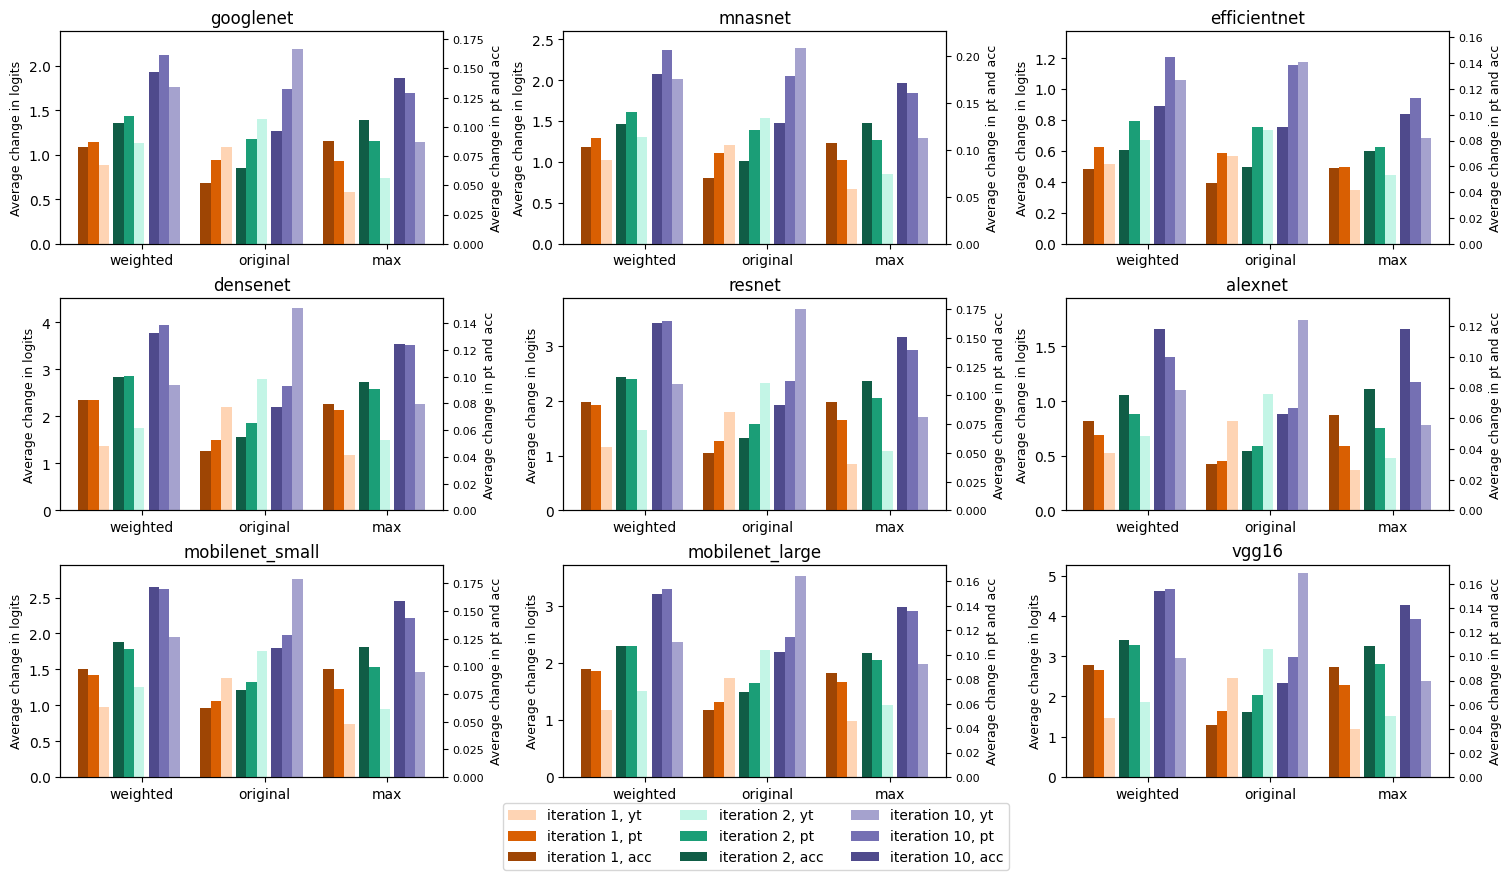

In [7]:
# Create the large plot!

results_folder = "/home/sofia/Results"
all_results = os.listdir(results_folder)
print(all_results)


colormapping = {
                "iteration 1, acc": "#9e4504",#  orange mörk
                "iteration 1, pt":  "#d95f02", # orange mellan
                "iteration 1, yt": "#fed4b4", #orange , ljus  
                "iteration 2, acc": "#105d46",# grön mörk
                "iteration 2, pt": "#1b9e77", #grön mellan 
                "iteration 2, yt":   "#c3f5e6", #grön, ljus                
                "iteration 10, acc": "#4f4a8c", # lila mörk 
                "iteration 10, pt":  "#7570b3", # lila mellan
                "iteration 10, yt": "#a5a2ce",  #lila, ljus
                }


fig, axs = plt.subplots(3,3, layout="constrained", figsize=(15, 8))
col = 0
row = 0
x = np.arange(len(perturbation_types))
x_tickes = [p_type for p_type in perturbation_types]
for i,file in enumerate(all_results):
    if file== "Oskar" or file==".ipynb_checkpoints" or "png" in file:
        continue
    model_name = file.split(".")[0]
    print(model_name)
    if len(model_name):
        with open(results_folder+"/"+file, 'r') as json_file:
            results_dict = json.load(json_file)
        measurements = get_measurements_dict(results_dict)    

        axs[row, col].set_title(model_name)
        width = 0.17
        multiplier = 0

        # Create the twin axis
        axs2 = axs[row, col].twinx()

        for attribute, measurement in measurements.items():
            offset = width * multiplier + 3*width
            if attribute.split(",")[1] == " yt":  
                rects = axs[row,col].bar(2*x + offset, measurement, width, label=attribute, color=colormapping[attribute])
                multiplier += 0.4
            else:
                rects = axs2.bar(2*x + offset, measurement, width, label=attribute, color=colormapping[attribute])
            multiplier += 1


        ylim_logit, ylim_acc = get_ylim(results_dict)
        
        axs2.set_xticks(2*x + width+1.3, x_tickes)
        axs2.set_ylim(0,0.025+ylim_acc)
        axs2.set_ylabel("Average change in pt and acc")
        axs2.xaxis.label.set_fontsize(9) 
        axs2.yaxis.label.set_fontsize(9)  
        axs2.tick_params(axis='both', which='both', labelsize=8)  #
               
        #axs[row, col].set_xticks(2*x + width+1, x_tickes)
        axs[row, col].set_ylim(0,0.25 + ylim_logit)
        axs[row, col].set_ylabel("Average change in logits")
        axs[row, col].xaxis.label.set_fontsize(9) 
        axs[row, col].yaxis.label.set_fontsize(9)  

        if row<2:
            row+=1
        elif row==2:
            row=0
            col += 1


order = [0,4,3,1,6,5,2,8,7]
lines, labels = axs[0,0].get_legend_handles_labels()
lines2, labels2 = axs2.get_legend_handles_labels()
tot_lines = lines+lines2
tot_labels = labels+labels2
fig.legend([tot_lines[i] for i in order], [tot_labels[i] for i in order], bbox_to_anchor =(0.5,-0.09), loc='lower center', ncols=3)

plt.savefig("./Results/total_plot_smaller.png", bbox_inches='tight')
plt.show()

